# COVID-19 Classification Using Capsule Networks on CT-Scan Images

## Introduction
In this notebook, we explore the application of capsule networks for the classification of COVID-19 using CT-scan images. Capsule networks, proposed by Geoffrey Hinton, are designed to overcome some of the limitations of traditional convolutional neural networks (CNNs) by preserving the hierarchical relationships between objects in an image. The goal of this project is to accurately classify CT-scan images into COVID-19 positive and negative categories using a capsule network architecture.

# SetUp

In [ ]:
!pip install opendatasets

import opendatasets as od

od.download("https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: atisatar
Your Kaggle Key: ··········


100%|██████████| 230M/230M [00:04<00:00, 53.6MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Dataset
### Data Description
The dataset used in this project consists of CT-scan images of patients with and without COVID-19. Each image is labeled accordingly. The dataset is sourced from https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset. It includes:
- **Number of images**: dataset is consist of about 1200 images of COVID-19 positive and negative cases for each class.
- **File format**: PNG


In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/sarscov2-ctscan-dataset/'
train_dir = os.path.join(data_dir)

In [ ]:
# ID = 0 -> COVID - ID = 1 -> NON-COVID
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (425).png,0,COVID
1,COVID/Covid (289).png,0,COVID
2,COVID/Covid (1125).png,0,COVID
3,COVID/Covid (75).png,0,COVID
4,COVID/Covid (918).png,0,COVID


In [ ]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1250).png,0,COVID
1,COVID/Covid (345).png,0,COVID
2,non-COVID/Non-Covid (396).png,1,non-COVID
3,non-COVID/Non-Covid (969).png,1,non-COVID
4,COVID/Covid (1138).png,0,COVID


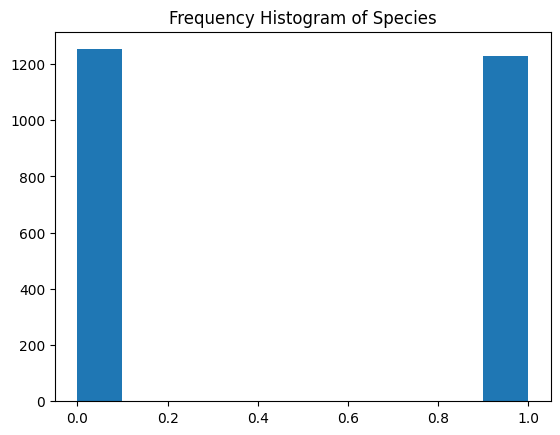

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

### COVID-19 examples

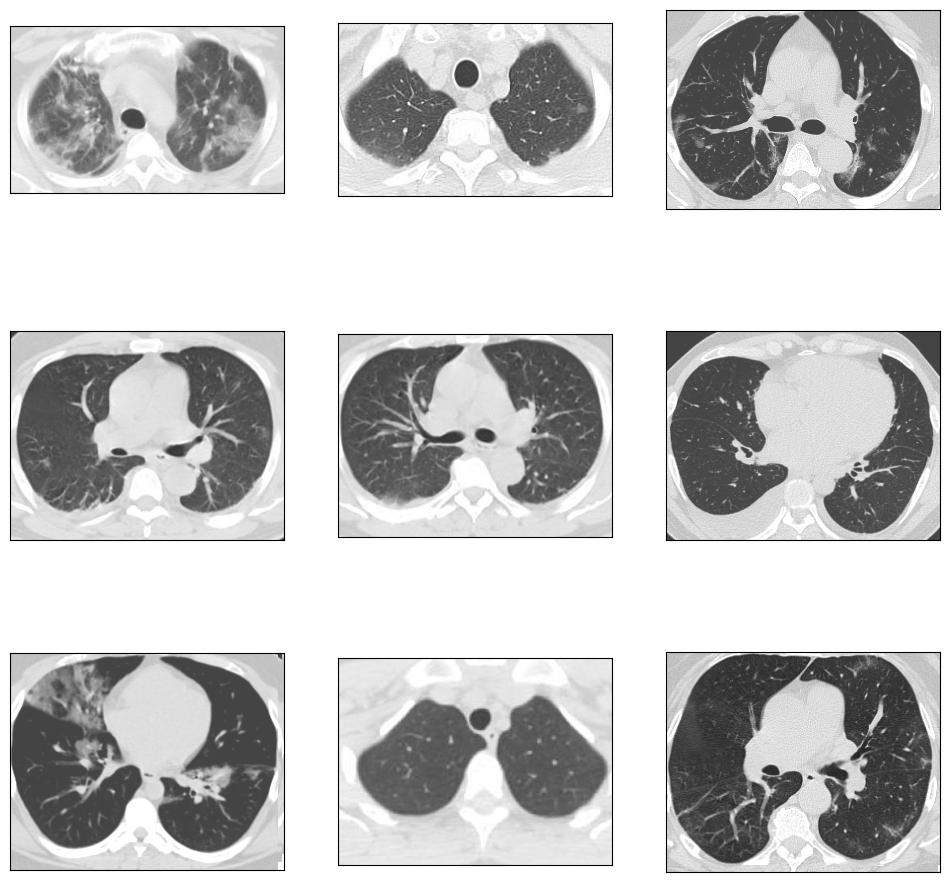

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 3, 3)

### Non-COVID examples

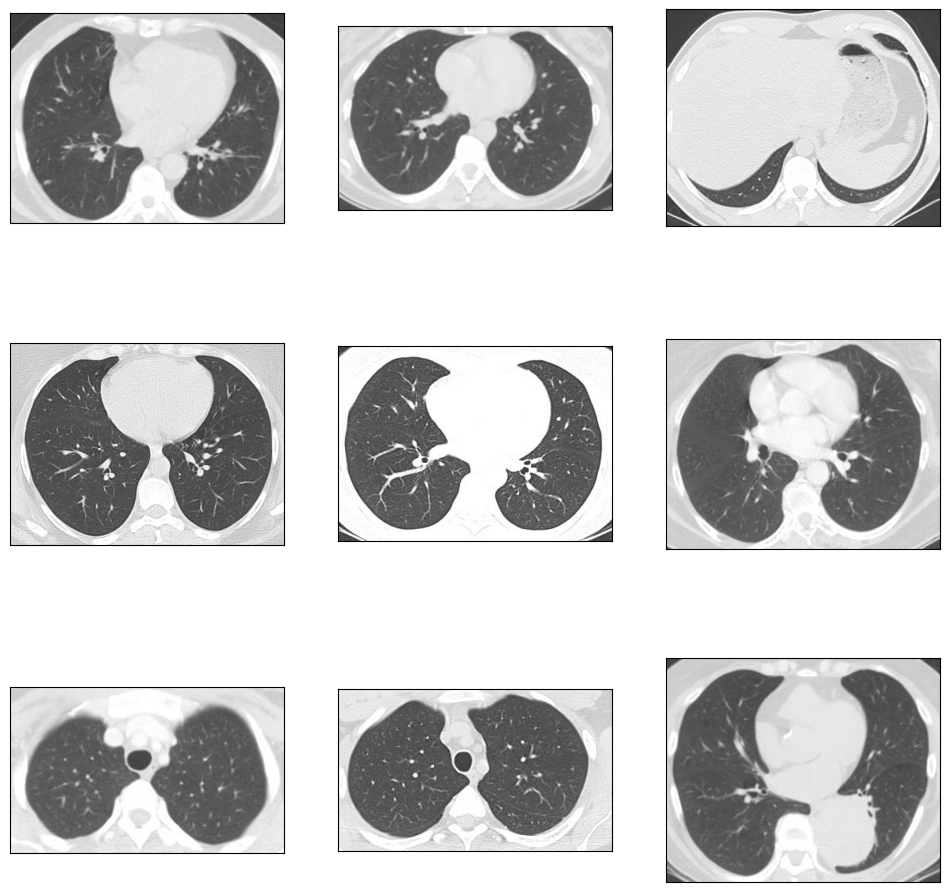

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 3, 3)

### Data Preprocessing
Data preprocessing is crucial for ensuring the quality and consistency of the input data. The following steps are performed:
1. **Resizing**: All images are resized to a uniform dimension suitable for the model.
2. **Normalization**: Pixel values are normalized to a range of [0, 1].
3. **Augmentation**: Techniques such as rotation, flipping, and zooming are applied to enhance the model's robustness.

In [ ]:
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:11, 211.17it/s]


Train Shape: (2481, 128, 128, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.4, random_state=SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=SEED)

### Data samples of each class 

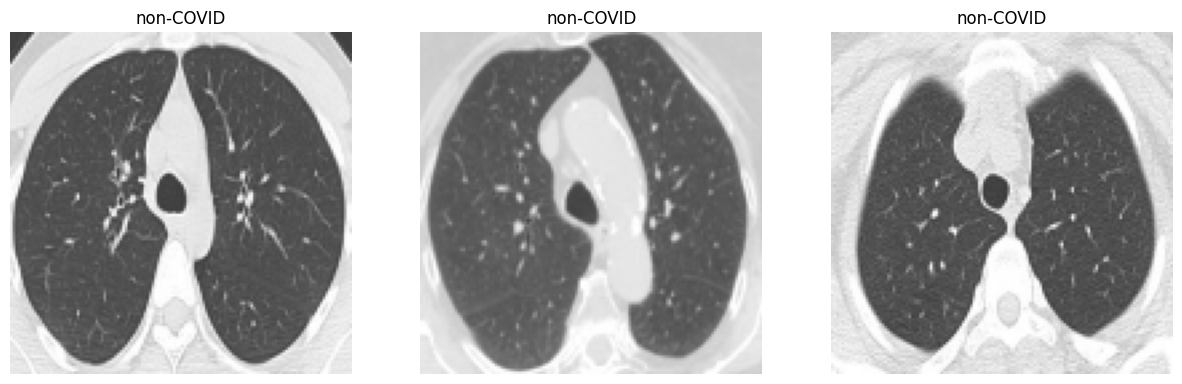

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
from matplotlib import pyplot as plt
import math


def plot_log(filename, show=True):

    data = pd.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

## Model

### Model Implementation

In [ ]:
import keras.backend as K
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):

      inputs_expand = tf.expand_dims(inputs, 1)
      inputs_tiled  = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])
      inputs_tiled  = tf.expand_dims(inputs_tiled, 4)



      inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)


      b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule,
                      self.input_num_capsule, 1, 1])

      assert self.routings > 0, 'The routings should be > 0.'
      for i in range(self.routings):

        c = layers.Softmax(axis=1)(b)

        outputs = tf.multiply(c, inputs_hat)
        outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
        outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]

        if i < self.routings - 1:
          outputs_tiled = tf.tile(outputs, [1, 1, self.input_num_capsule, 1, 1])
          agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
          b = tf.add(b, agreement)

      outputs = tf.squeeze(outputs, [2, 4])
      return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


### Model training 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 120, 25  62464       ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 primarycap_conv2d (Conv2D)     (None, 56, 56, 256)  5308672     ['conv1[0][0]']                  
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.4445 - capsnet_loss: 0.4080 - decoder_loss: 0.0929 - capsnet_accuracy: 0.5060

47/47 [==============================] - 76s 1s/step - loss: 0.4445 - capsnet_loss: 0.4080 - decoder_loss: 0.0929 - capsnet_accuracy: 0.5060 - val_loss: 0.4382 - val_capsnet_loss: 0.4020 - val_decoder_loss: 0.0923 - val_capsnet_accuracy: 0.4617 - lr: 1.0000e-04
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 0.4402 - capsnet_loss: 0.4042 - decoder_loss: 0.0919 - capsnet_accuracy: 0.4886

47/47 [==============================] - 46s 981ms/step - loss: 0.4402 - capsnet_loss: 0.4042 - decoder_loss: 0.0919 - capsnet_accuracy: 0.4886 - val_loss: 0.4395 - val_capsnet_loss: 0.4043 - val_decoder_loss: 0.0898 - val_capsnet_accuracy: 0.5383 - lr: 9.0000e-05
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.4367 - capsnet_loss: 0.4038 - decoder_loss: 0.0839 - capsnet_accuracy: 0.4839

47/47 [==============================] - 47s 998ms/step - loss: 0.4367 - capsnet_loss: 0.4038 - decoder_loss: 0.0839 - capsnet_accuracy: 0.4839 - val_loss: 0.4303 - val_capsnet_loss: 0.4023 - val_decoder_loss: 0.0717 - val_capsnet_accuracy: 0.5383 - lr: 8.1000e-05
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 0.4239 - capsnet_loss: 0.3959 - decoder_loss: 0.0715 - capsnet_accuracy: 0.4765

47/47 [==============================] - 46s 975ms/step - loss: 0.4239 - capsnet_loss: 0.3959 - decoder_loss: 0.0715 - capsnet_accuracy: 0.4765 - val_loss: 0.4289 - val_capsnet_loss: 0.4048 - val_decoder_loss: 0.0614 - val_capsnet_accuracy: 0.5383 - lr: 7.2900e-05
Epoch 5/100
47/47 [==============================] - ETA: 0s - loss: 0.4246 - capsnet_loss: 0.4048 - decoder_loss: 0.0505 - capsnet_accuracy: 0.4839

47/47 [==============================] - 46s 986ms/step - loss: 0.4246 - capsnet_loss: 0.4048 - decoder_loss: 0.0505 - capsnet_accuracy: 0.4839 - val_loss: 0.4216 - val_capsnet_loss: 0.4048 - val_decoder_loss: 0.0427 - val_capsnet_accuracy: 0.5383 - lr: 6.5610e-05
Epoch 6/100
47/47 [==============================] - ETA: 0s - loss: 0.4212 - capsnet_loss: 0.4048 - decoder_loss: 0.0418 - capsnet_accuracy: 0.4839

47/47 [==============================] - 48s 1s/step - loss: 0.4212 - capsnet_loss: 0.4048 - decoder_loss: 0.0418 - capsnet_accuracy: 0.4839 - val_loss: 0.4209 - val_capsnet_loss: 0.4048 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.5383 - lr: 5.9049e-05
Epoch 7/100
47/47 [==============================] - ETA: 0s - loss: 0.4209 - capsnet_loss: 0.4048 - decoder_loss: 0.0411 - capsnet_accuracy: 0.4839

47/47 [==============================] - 47s 999ms/step - loss: 0.4209 - capsnet_loss: 0.4048 - decoder_loss: 0.0411 - capsnet_accuracy: 0.4839 - val_loss: 0.4208 - val_capsnet_loss: 0.4048 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.5383 - lr: 5.3144e-05
Epoch 8/100
47/47 [==============================] - ETA: 0s - loss: 0.4208 - capsnet_loss: 0.4047 - decoder_loss: 0.0410 - capsnet_accuracy: 0.4839

47/47 [==============================] - 47s 1s/step - loss: 0.4208 - capsnet_loss: 0.4047 - decoder_loss: 0.0410 - capsnet_accuracy: 0.4839 - val_loss: 0.4198 - val_capsnet_loss: 0.4038 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.5383 - lr: 4.7830e-05
Epoch 9/100
47/47 [==============================] - ETA: 0s - loss: 0.4119 - capsnet_loss: 0.3955 - decoder_loss: 0.0417 - capsnet_accuracy: 0.4933

47/47 [==============================] - 47s 1s/step - loss: 0.4119 - capsnet_loss: 0.3955 - decoder_loss: 0.0417 - capsnet_accuracy: 0.4933 - val_loss: 0.4200 - val_capsnet_loss: 0.4039 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.5383 - lr: 4.3047e-05
Epoch 10/100
47/47 [==============================] - ETA: 0s - loss: 0.4183 - capsnet_loss: 0.4022 - decoder_loss: 0.0412 - capsnet_accuracy: 0.4839

47/47 [==============================] - 47s 1s/step - loss: 0.4183 - capsnet_loss: 0.4022 - decoder_loss: 0.0412 - capsnet_accuracy: 0.4839 - val_loss: 0.3880 - val_capsnet_loss: 0.3711 - val_decoder_loss: 0.0429 - val_capsnet_accuracy: 0.5383 - lr: 3.8742e-05
Epoch 11/100
47/47 [==============================] - ETA: 0s - loss: 0.2821 - capsnet_loss: 0.2652 - decoder_loss: 0.0432 - capsnet_accuracy: 0.5208

47/47 [==============================] - 49s 1s/step - loss: 0.2821 - capsnet_loss: 0.2652 - decoder_loss: 0.0432 - capsnet_accuracy: 0.5208 - val_loss: 0.2080 - val_capsnet_loss: 0.1916 - val_decoder_loss: 0.0419 - val_capsnet_accuracy: 0.5544 - lr: 3.4868e-05
Epoch 12/100
47/47 [==============================] - ETA: 0s - loss: 0.1930 - capsnet_loss: 0.1767 - decoder_loss: 0.0416 - capsnet_accuracy: 0.7043

47/47 [==============================] - 49s 1s/step - loss: 0.1930 - capsnet_loss: 0.1767 - decoder_loss: 0.0416 - capsnet_accuracy: 0.7043 - val_loss: 0.1669 - val_capsnet_loss: 0.1508 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.7762 - lr: 3.1381e-05
Epoch 13/100
47/47 [==============================] - ETA: 0s - loss: 0.1549 - capsnet_loss: 0.1387 - decoder_loss: 0.0413 - capsnet_accuracy: 0.7823

47/47 [==============================] - 48s 1s/step - loss: 0.1549 - capsnet_loss: 0.1387 - decoder_loss: 0.0413 - capsnet_accuracy: 0.7823 - val_loss: 0.1472 - val_capsnet_loss: 0.1311 - val_decoder_loss: 0.0412 - val_capsnet_accuracy: 0.7944 - lr: 2.8243e-05
Epoch 14/100
47/47 [==============================] - ETA: 0s - loss: 0.1292 - capsnet_loss: 0.1130 - decoder_loss: 0.0413 - capsnet_accuracy: 0.8280

47/47 [==============================] - 50s 1s/step - loss: 0.1292 - capsnet_loss: 0.1130 - decoder_loss: 0.0413 - capsnet_accuracy: 0.8280 - val_loss: 0.1269 - val_capsnet_loss: 0.1108 - val_decoder_loss: 0.0411 - val_capsnet_accuracy: 0.8206 - lr: 2.5419e-05
Epoch 15/100
47/47 [==============================] - ETA: 0s - loss: 0.1108 - capsnet_loss: 0.0947 - decoder_loss: 0.0412 - capsnet_accuracy: 0.8575

47/47 [==============================] - 50s 1s/step - loss: 0.1108 - capsnet_loss: 0.0947 - decoder_loss: 0.0412 - capsnet_accuracy: 0.8575 - val_loss: 0.1121 - val_capsnet_loss: 0.0960 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.8488 - lr: 2.2877e-05
Epoch 16/100
47/47 [==============================] - ETA: 0s - loss: 0.0955 - capsnet_loss: 0.0793 - decoder_loss: 0.0412 - capsnet_accuracy: 0.8864

47/47 [==============================] - 48s 1s/step - loss: 0.0955 - capsnet_loss: 0.0793 - decoder_loss: 0.0412 - capsnet_accuracy: 0.8864 - val_loss: 0.1062 - val_capsnet_loss: 0.0902 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.8730 - lr: 2.0589e-05
Epoch 17/100
47/47 [==============================] - ETA: 0s - loss: 0.0916 - capsnet_loss: 0.0755 - decoder_loss: 0.0411 - capsnet_accuracy: 0.8858

47/47 [==============================] - 49s 1s/step - loss: 0.0916 - capsnet_loss: 0.0755 - decoder_loss: 0.0411 - capsnet_accuracy: 0.8858 - val_loss: 0.1120 - val_capsnet_loss: 0.0959 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.8468 - lr: 1.8530e-05
Epoch 18/100
47/47 [==============================] - ETA: 0s - loss: 0.0804 - capsnet_loss: 0.0643 - decoder_loss: 0.0411 - capsnet_accuracy: 0.9059

47/47 [==============================] - 49s 1s/step - loss: 0.0804 - capsnet_loss: 0.0643 - decoder_loss: 0.0411 - capsnet_accuracy: 0.9059 - val_loss: 0.1039 - val_capsnet_loss: 0.0878 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.8851 - lr: 1.6677e-05
Epoch 19/100
47/47 [==============================] - ETA: 0s - loss: 0.0763 - capsnet_loss: 0.0602 - decoder_loss: 0.0411 - capsnet_accuracy: 0.9173

47/47 [==============================] - 49s 1s/step - loss: 0.0763 - capsnet_loss: 0.0602 - decoder_loss: 0.0411 - capsnet_accuracy: 0.9173 - val_loss: 0.1009 - val_capsnet_loss: 0.0848 - val_decoder_loss: 0.0410 - val_capsnet_accuracy: 0.8891 - lr: 1.5009e-05
Epoch 20/100
47/47 [==============================] - ETA: 0s - loss: 0.0714 - capsnet_loss: 0.0553 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9294

47/47 [==============================] - 49s 1s/step - loss: 0.0714 - capsnet_loss: 0.0553 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9294 - val_loss: 0.0961 - val_capsnet_loss: 0.0801 - val_decoder_loss: 0.0409 - val_capsnet_accuracy: 0.8891 - lr: 1.3509e-05
Epoch 21/100
47/47 [==============================] - ETA: 0s - loss: 0.0666 - capsnet_loss: 0.0505 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9362

47/47 [==============================] - 50s 1s/step - loss: 0.0666 - capsnet_loss: 0.0505 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9362 - val_loss: 0.0937 - val_capsnet_loss: 0.0777 - val_decoder_loss: 0.0409 - val_capsnet_accuracy: 0.8992 - lr: 1.2158e-05
Epoch 22/100
47/47 [==============================] - ETA: 0s - loss: 0.0628 - capsnet_loss: 0.0467 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9435

47/47 [==============================] - 50s 1s/step - loss: 0.0628 - capsnet_loss: 0.0467 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9435 - val_loss: 0.0925 - val_capsnet_loss: 0.0765 - val_decoder_loss: 0.0409 - val_capsnet_accuracy: 0.9052 - lr: 1.0942e-05
Epoch 23/100
47/47 [==============================] - ETA: 0s - loss: 0.0618 - capsnet_loss: 0.0457 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9516

47/47 [==============================] - 50s 1s/step - loss: 0.0618 - capsnet_loss: 0.0457 - decoder_loss: 0.0410 - capsnet_accuracy: 0.9516 - val_loss: 0.0964 - val_capsnet_loss: 0.0804 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.8911 - lr: 9.8477e-06
Epoch 24/100
47/47 [==============================] - ETA: 0s - loss: 0.0580 - capsnet_loss: 0.0419 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9523

47/47 [==============================] - 49s 1s/step - loss: 0.0580 - capsnet_loss: 0.0419 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9523 - val_loss: 0.0926 - val_capsnet_loss: 0.0766 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.9032 - lr: 8.8629e-06
Epoch 25/100
47/47 [==============================] - ETA: 0s - loss: 0.0553 - capsnet_loss: 0.0393 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9563

47/47 [==============================] - 49s 1s/step - loss: 0.0553 - capsnet_loss: 0.0393 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9563 - val_loss: 0.0916 - val_capsnet_loss: 0.0756 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.9113 - lr: 7.9766e-06
Epoch 26/100
47/47 [==============================] - ETA: 0s - loss: 0.0533 - capsnet_loss: 0.0373 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9597

47/47 [==============================] - 50s 1s/step - loss: 0.0533 - capsnet_loss: 0.0373 - decoder_loss: 0.0409 - capsnet_accuracy: 0.9597 - val_loss: 0.0915 - val_capsnet_loss: 0.0755 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.9073 - lr: 7.1790e-06
Epoch 27/100
47/47 [==============================] - ETA: 0s - loss: 0.0516 - capsnet_loss: 0.0356 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9677

47/47 [==============================] - 49s 1s/step - loss: 0.0516 - capsnet_loss: 0.0356 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9677 - val_loss: 0.0924 - val_capsnet_loss: 0.0765 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.9052 - lr: 6.4611e-06
Epoch 28/100
47/47 [==============================] - ETA: 0s - loss: 0.0498 - capsnet_loss: 0.0338 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9691

47/47 [==============================] - 49s 1s/step - loss: 0.0498 - capsnet_loss: 0.0338 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9691 - val_loss: 0.0936 - val_capsnet_loss: 0.0777 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.9052 - lr: 5.8150e-06
Epoch 29/100
47/47 [==============================] - ETA: 0s - loss: 0.0489 - capsnet_loss: 0.0329 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9684

47/47 [==============================] - 50s 1s/step - loss: 0.0489 - capsnet_loss: 0.0329 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9684 - val_loss: 0.1025 - val_capsnet_loss: 0.0865 - val_decoder_loss: 0.0408 - val_capsnet_accuracy: 0.8851 - lr: 5.2335e-06
Epoch 30/100
47/47 [==============================] - ETA: 0s - loss: 0.0493 - capsnet_loss: 0.0333 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9684

47/47 [==============================] - 50s 1s/step - loss: 0.0493 - capsnet_loss: 0.0333 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9684 - val_loss: 0.0951 - val_capsnet_loss: 0.0792 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.8992 - lr: 4.7101e-06
Epoch 31/100
47/47 [==============================] - ETA: 0s - loss: 0.0467 - capsnet_loss: 0.0307 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9738

47/47 [==============================] - 49s 1s/step - loss: 0.0467 - capsnet_loss: 0.0307 - decoder_loss: 0.0408 - capsnet_accuracy: 0.9738 - val_loss: 0.0901 - val_capsnet_loss: 0.0741 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.9093 - lr: 4.2391e-06
Epoch 32/100
47/47 [==============================] - ETA: 0s - loss: 0.0456 - capsnet_loss: 0.0296 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9731

47/47 [==============================] - 49s 1s/step - loss: 0.0456 - capsnet_loss: 0.0296 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9731 - val_loss: 0.0900 - val_capsnet_loss: 0.0740 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.9153 - lr: 3.8152e-06
Epoch 33/100
47/47 [==============================] - ETA: 0s - loss: 0.0445 - capsnet_loss: 0.0285 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9751

47/47 [==============================] - 50s 1s/step - loss: 0.0445 - capsnet_loss: 0.0285 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9751 - val_loss: 0.0909 - val_capsnet_loss: 0.0750 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.9093 - lr: 3.4337e-06
Epoch 34/100
47/47 [==============================] - ETA: 0s - loss: 0.0439 - capsnet_loss: 0.0280 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9758

47/47 [==============================] - 49s 1s/step - loss: 0.0439 - capsnet_loss: 0.0280 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9758 - val_loss: 0.0902 - val_capsnet_loss: 0.0742 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.9173 - lr: 3.0903e-06
Epoch 35/100
47/47 [==============================] - ETA: 0s - loss: 0.0435 - capsnet_loss: 0.0275 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9765

47/47 [==============================] - 50s 1s/step - loss: 0.0435 - capsnet_loss: 0.0275 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9765 - val_loss: 0.0911 - val_capsnet_loss: 0.0751 - val_decoder_loss: 0.0407 - val_capsnet_accuracy: 0.9052 - lr: 2.7813e-06
Epoch 36/100
47/47 [==============================] - ETA: 0s - loss: 0.0425 - capsnet_loss: 0.0266 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9785

47/47 [==============================] - 49s 1s/step - loss: 0.0425 - capsnet_loss: 0.0266 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9785 - val_loss: 0.0905 - val_capsnet_loss: 0.0746 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9153 - lr: 2.5032e-06
Epoch 37/100
47/47 [==============================] - ETA: 0s - loss: 0.0420 - capsnet_loss: 0.0260 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9792

47/47 [==============================] - 50s 1s/step - loss: 0.0420 - capsnet_loss: 0.0260 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9792 - val_loss: 0.0905 - val_capsnet_loss: 0.0746 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9113 - lr: 2.2528e-06
Epoch 38/100
47/47 [==============================] - ETA: 0s - loss: 0.0418 - capsnet_loss: 0.0259 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9778

47/47 [==============================] - 49s 1s/step - loss: 0.0418 - capsnet_loss: 0.0259 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9778 - val_loss: 0.0900 - val_capsnet_loss: 0.0741 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9113 - lr: 2.0276e-06
Epoch 39/100
47/47 [==============================] - ETA: 0s - loss: 0.0413 - capsnet_loss: 0.0253 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9812

47/47 [==============================] - 50s 1s/step - loss: 0.0413 - capsnet_loss: 0.0253 - decoder_loss: 0.0407 - capsnet_accuracy: 0.9812 - val_loss: 0.0911 - val_capsnet_loss: 0.0752 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9133 - lr: 1.8248e-06
Epoch 40/100
47/47 [==============================] - ETA: 0s - loss: 0.0409 - capsnet_loss: 0.0250 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9805

47/47 [==============================] - 50s 1s/step - loss: 0.0409 - capsnet_loss: 0.0250 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9805 - val_loss: 0.0898 - val_capsnet_loss: 0.0739 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9113 - lr: 1.6423e-06
Epoch 41/100
47/47 [==============================] - ETA: 0s - loss: 0.0405 - capsnet_loss: 0.0246 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9798

47/47 [==============================] - 49s 1s/step - loss: 0.0405 - capsnet_loss: 0.0246 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9798 - val_loss: 0.0898 - val_capsnet_loss: 0.0739 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9133 - lr: 1.4781e-06
Epoch 42/100
47/47 [==============================] - ETA: 0s - loss: 0.0401 - capsnet_loss: 0.0242 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9798

47/47 [==============================] - 49s 1s/step - loss: 0.0401 - capsnet_loss: 0.0242 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9798 - val_loss: 0.0907 - val_capsnet_loss: 0.0748 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9073 - lr: 1.3303e-06
Epoch 43/100
47/47 [==============================] - ETA: 0s - loss: 0.0398 - capsnet_loss: 0.0238 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9805

47/47 [==============================] - 49s 1s/step - loss: 0.0398 - capsnet_loss: 0.0238 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9805 - val_loss: 0.0904 - val_capsnet_loss: 0.0745 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9073 - lr: 1.1973e-06
Epoch 44/100
47/47 [==============================] - ETA: 0s - loss: 0.0396 - capsnet_loss: 0.0237 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9819

47/47 [==============================] - 49s 1s/step - loss: 0.0396 - capsnet_loss: 0.0237 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9819 - val_loss: 0.0901 - val_capsnet_loss: 0.0741 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9173 - lr: 1.0775e-06
Epoch 45/100
47/47 [==============================] - ETA: 0s - loss: 0.0393 - capsnet_loss: 0.0234 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825

47/47 [==============================] - 49s 1s/step - loss: 0.0393 - capsnet_loss: 0.0234 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825 - val_loss: 0.0903 - val_capsnet_loss: 0.0744 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9153 - lr: 9.6977e-07
Epoch 46/100
47/47 [==============================] - ETA: 0s - loss: 0.0391 - capsnet_loss: 0.0232 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9819

47/47 [==============================] - 50s 1s/step - loss: 0.0391 - capsnet_loss: 0.0232 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9819 - val_loss: 0.0900 - val_capsnet_loss: 0.0741 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9133 - lr: 8.7280e-07
Epoch 47/100
47/47 [==============================] - ETA: 0s - loss: 0.0390 - capsnet_loss: 0.0231 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9812

47/47 [==============================] - 50s 1s/step - loss: 0.0390 - capsnet_loss: 0.0231 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9812 - val_loss: 0.0908 - val_capsnet_loss: 0.0749 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9093 - lr: 7.8552e-07
Epoch 48/100
47/47 [==============================] - ETA: 0s - loss: 0.0388 - capsnet_loss: 0.0229 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9832

47/47 [==============================] - 50s 1s/step - loss: 0.0388 - capsnet_loss: 0.0229 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9832 - val_loss: 0.0915 - val_capsnet_loss: 0.0756 - val_decoder_loss: 0.0405 - val_capsnet_accuracy: 0.9052 - lr: 7.0697e-07
Epoch 49/100
47/47 [==============================] - ETA: 0s - loss: 0.0387 - capsnet_loss: 0.0228 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825

47/47 [==============================] - 50s 1s/step - loss: 0.0387 - capsnet_loss: 0.0228 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825 - val_loss: 0.0904 - val_capsnet_loss: 0.0745 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9113 - lr: 6.3627e-07
Epoch 50/100
47/47 [==============================] - ETA: 0s - loss: 0.0386 - capsnet_loss: 0.0227 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9832

47/47 [==============================] - 50s 1s/step - loss: 0.0386 - capsnet_loss: 0.0227 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9832 - val_loss: 0.0901 - val_capsnet_loss: 0.0742 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9153 - lr: 5.7264e-07
Epoch 51/100
47/47 [==============================] - ETA: 0s - loss: 0.0384 - capsnet_loss: 0.0225 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825

47/47 [==============================] - 49s 1s/step - loss: 0.0384 - capsnet_loss: 0.0225 - decoder_loss: 0.0406 - capsnet_accuracy: 0.9825 - val_loss: 0.0909 - val_capsnet_loss: 0.0750 - val_decoder_loss: 0.0406 - val_capsnet_accuracy: 0.9133 - lr: 5.1538e-07
Trained model saved to './result/trained_model.h5'


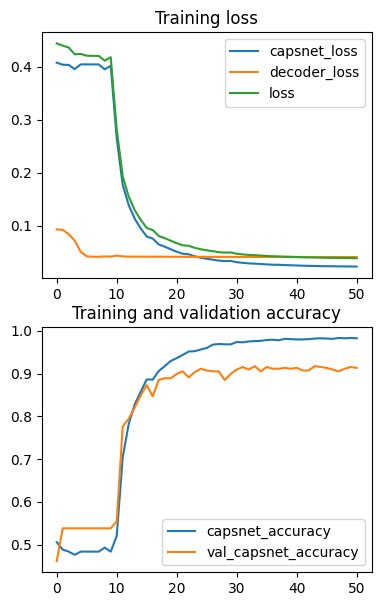

In [ ]:
from keras import layers, models, optimizers
from keras import backend as K
import matplotlib.pyplot as plt
import os 
from keras import callbacks


K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    return train_model ,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(HYPERPARAMETERS["SAVE_DIR"] + '/log.csv')
    tb = callbacks.TensorBoard(log_dir= HYPERPARAMETERS["SAVE_DIR"] + '/tensorboard-logs',
                               batch_size= HYPERPARAMETERS["BATCH_SIZE"])
    checkpoint = callbacks.ModelCheckpoint(HYPERPARAMETERS["SAVE_DIR"] + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: HYPERPARAMETERS["LR"] * (HYPERPARAMETERS["lr_decay"] ** epoch))
    es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=HYPERPARAMETERS["LR"]),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., HYPERPARAMETERS["lam_recon"]],
                  metrics={'capsnet': 'accuracy'})

    model.fit([x_train, y_train], [y_train, x_train], batch_size=HYPERPARAMETERS["BATCH_SIZE"], epochs=HYPERPARAMETERS["EPOCHS"],
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay,es])


    model.save_weights(HYPERPARAMETERS["SAVE_DIR"] + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % HYPERPARAMETERS["SAVE_DIR"])

    # from utils import plot_log
    plot_log(HYPERPARAMETERS["SAVE_DIR"] + '/log.csv', show=True)

    return model


HYPERPARAMETERS = {"EPOCHS": 100 , "BATCH_SIZE":  32, "LR" : 0.0001 ,"lr_decay" : 0.9 , "lam_recon" : 0.392 , "shift_fraction" : 0.1 , "ROUTINGS" : 3 , "SAVE_DIR" : './result' ,"digit" : 5}


if not os.path.exists(HYPERPARAMETERS["SAVE_DIR"]):
    os.makedirs(HYPERPARAMETERS["SAVE_DIR"])

# define model
train_model ,eval_model = CapsNet(input_shape=X_train.shape[1:],
                                n_class=len(np.unique(np.argmax(Y_train, 1))),
                                routings=HYPERPARAMETERS["ROUTINGS"])

train_model.summary()
train(model=train_model, data=((X_train, Y_train), (X_val, Y_val)), args=HYPERPARAMETERS)

### performance evaluation

5/5 [==============================] - 33s 4s/step
------------------------------Begin: test------------------------------
Test acc: 0.9255533199195171


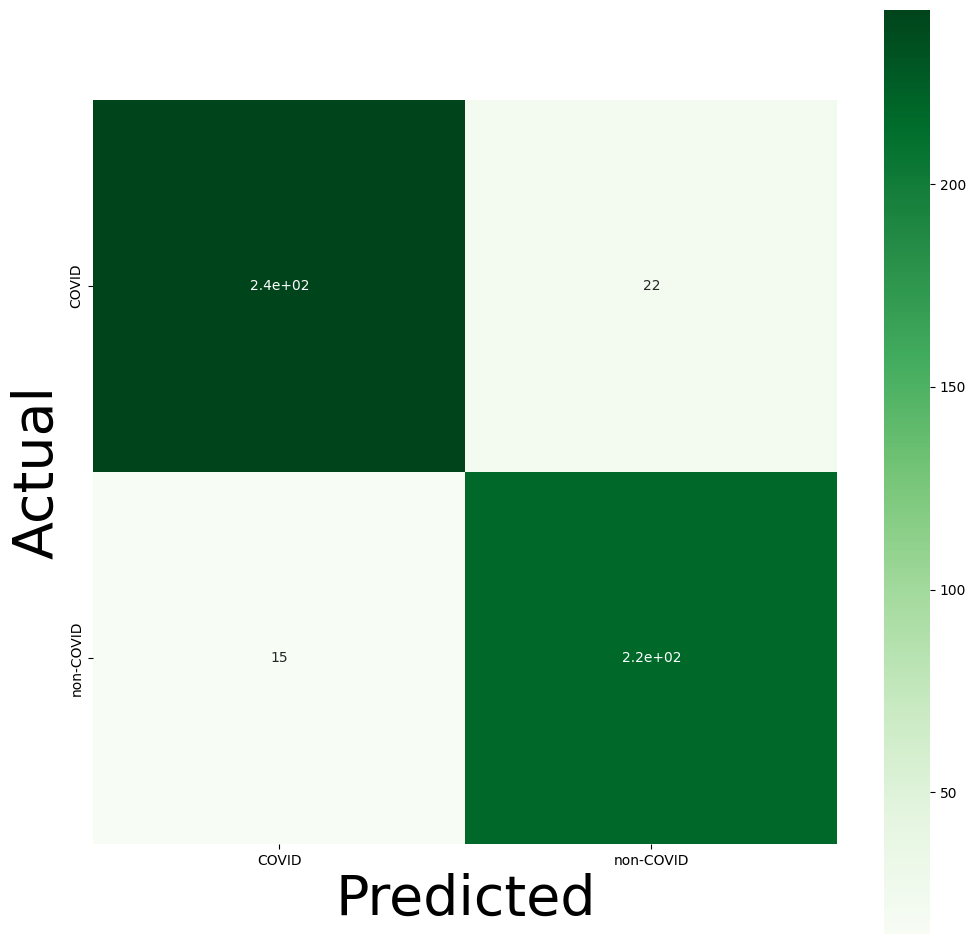

In [ ]:
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    Y_pred = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
    ax.set_ylabel('Actual', fontsize=40)
    ax.set_xlabel('Predicted', fontsize=40)

test(model=eval_model, data=(X_test, Y_test))